<a href="https://colab.research.google.com/github/vivekvj18/ML-PROJECT-2/blob/main/ML_2_Logistic_linearSVM_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from scipy.stats import zscore

sns.set(style="whitegrid")
pd.set_option('display.max_columns', 200)

# Load dataset
df = pd.read_csv("covtype.csv")
print("Loaded dataset shape:", df.shape)
df.head()

Loaded dataset shape: (581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [ ]:
continuous_cols = [
    'Elevation','Aspect','Slope',
    'Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]

target_col = 'Cover_Type'  # standard name in UCI dataset

feature_cols = [c for c in df.columns if c != target_col]
binary_cols = [c for c in feature_cols if c not in continuous_cols]

print("Total Features:", len(feature_cols))
print("Continuous Features:", continuous_cols)
print("Binary/One-Hot Features:", len(binary_cols))
print("\nTarget Distribution:")
print(df[target_col].value_counts().sort_index())

Total Features: 54
Continuous Features: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
Binary/One-Hot Features: 44

Target Distribution:
Cover_Type
1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
Name: count, dtype: int64


Total missing values: 0


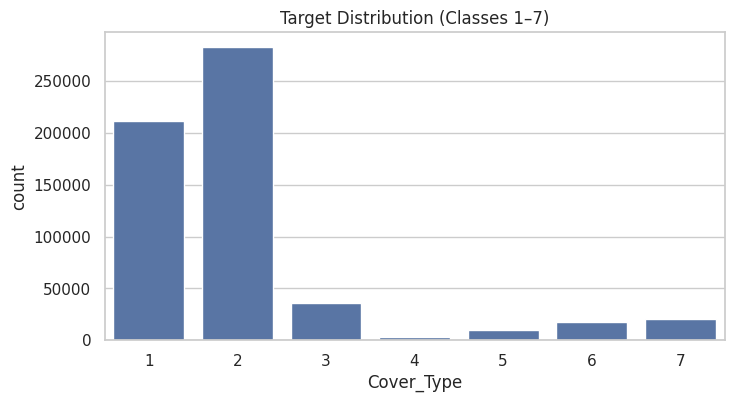

In [ ]:

print("Total missing values:", df.isnull().sum().sum())

plt.figure(figsize=(8,4))
sns.countplot(x=target_col, data=df, order=sorted(df[target_col].unique()))
plt.title("Target Distribution (Classes 1–7)")
plt.show()


,count,mean,std,min,25%,50%,75%,max
Elevation,581012.0,2959.365301,279.984734,1859.0,2809.0,2996.0,3163.0,3858.0
Aspect,581012.0,155.656807,111.913721,0.0,58.0,127.0,260.0,360.0
Slope,581012.0,14.103704,7.488242,0.0,9.0,13.0,18.0,66.0
Horizontal_Distance_To_Hydrology,581012.0,269.428217,212.549356,0.0,108.0,218.0,384.0,1397.0
Vertical_Distance_To_Hydrology,581012.0,46.418855,58.295232,-173.0,7.0,30.0,69.0,601.0
Horizontal_Distance_To_Roadways,581012.0,2350.146611,1559.254870,0.0,1106.0,1997.0,3328.0,7117.0
Hillshade_9am,581012.0,212.146049,26.769889,0.0,198.0,218.0,231.0,254.0
Hillshade_Noon,581012.0,223.318716,19.768697,0.0,213.0,226.0,237.0,254.0
Hillshade_3pm,581012.0,142.528263,38.274529,0.0,119.0,143.0,168.0,254.0
Horizontal_Distance_To_Fire_Points,581012.0,1980.291226,1324.195210,0.0,1024.0,1710.0,2550.0,7173.0


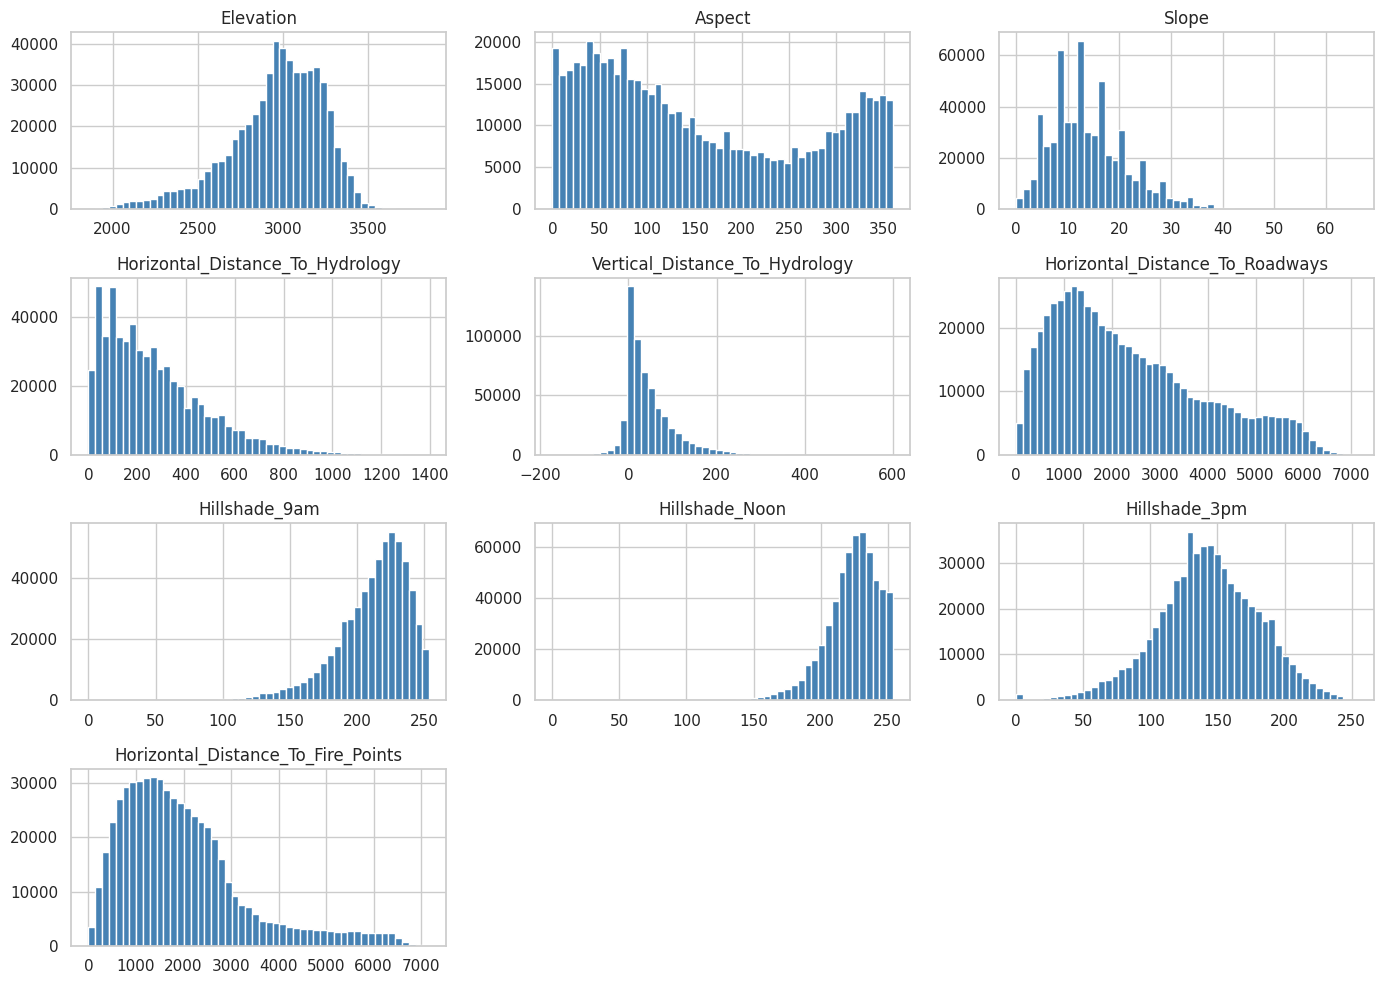

In [ ]:
display(df[continuous_cols].describe().T)

plt.figure(figsize=(14,10))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(4,3,i)
    plt.hist(df[col], bins=50, color='steelblue')
    plt.title(col)
plt.tight_layout()
plt.show()


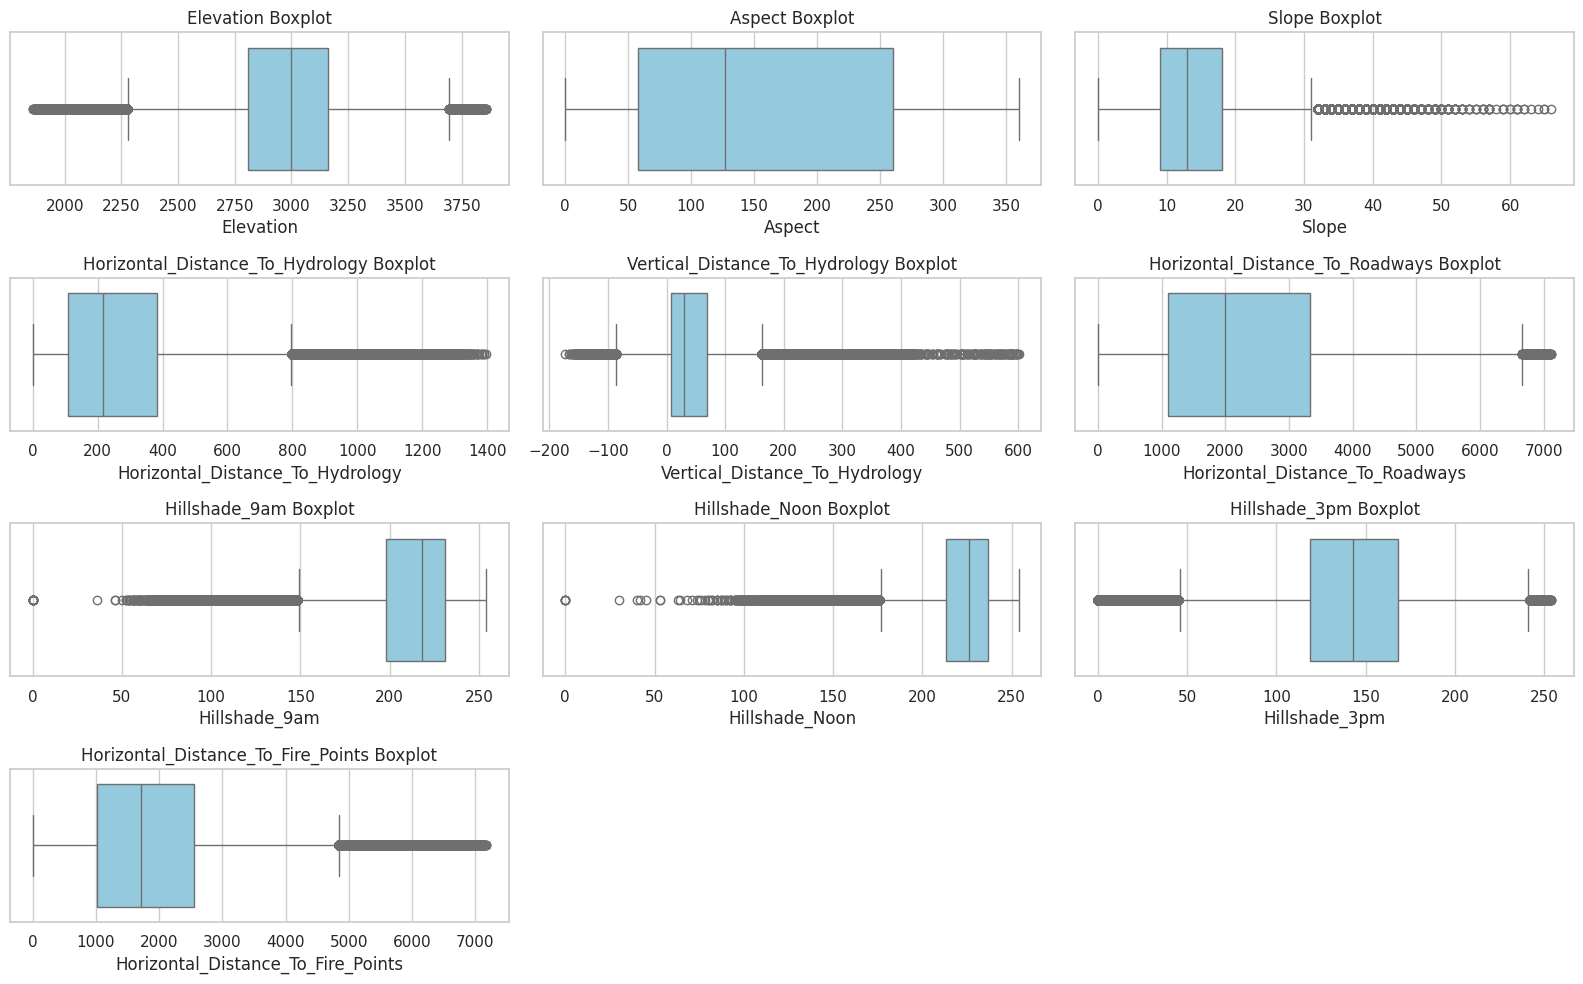

Outlier Counts (Z > |3|):
Horizontal_Distance_To_Fire_Points    10853
Vertical_Distance_To_Hydrology        10059
Hillshade_9am                          7516
Hillshade_Noon                         7082
Horizontal_Distance_To_Hydrology       7073
Elevation                              5832
Slope                                  4074
Hillshade_3pm                          3042
Horizontal_Distance_To_Roadways          33
Aspect                                    0
dtype: int64

Total Outlier Points: 55564


In [ ]:
# Boxplots
plt.figure(figsize=(16,10))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(4,3,i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f"{col} Boxplot")
plt.tight_layout()
plt.show()

# Z-score outliers
df_z = df[continuous_cols].apply(zscore)
outlier_counts = (np.abs(df_z) > 3).sum().sort_values(ascending=False)
print("Outlier Counts (Z > |3|):")
print(outlier_counts)

print("\nTotal Outlier Points:", int((np.abs(df_z) > 3).sum().sum()))

#Outliers represent natural geographic variation; therefore, we DO NOT remove them

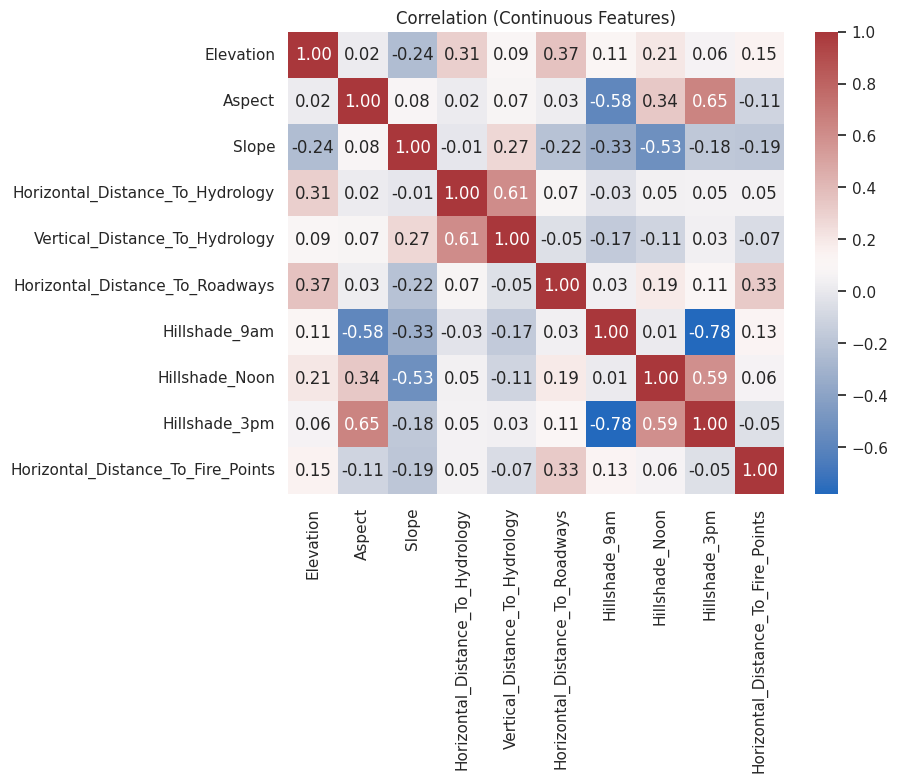

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df[continuous_cols].corr(), annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation (Continuous Features)")
plt.show()

In [ ]:
print("Original shape:", df.shape)

# 1) Remove rows where target is NaN
nan_target = df[target_col].isnull().sum()
print("NaN in target column:", nan_target)

if nan_target > 0:
    df = df.dropna(subset=[target_col]).reset_index(drop=True)
    print(f"Dropped {nan_target} rows with NaN target.")
else:
    print("No NaN in target. Proceeding.")

# 2) Replace inf → NaN → drop
df = df.replace([np.inf, -np.inf], np.nan)
nan_features = df.isnull().sum().sum() - df[target_col].isnull().sum()

if nan_features > 0:
    print(f"Found {nan_features} NaN in features. Dropping affected rows.")
    df = df.dropna().reset_index(drop=True)
else:
    print("No NaN or inf in features.")

print("Shape after cleaning:", df.shape)

# 3) Final X, y
X = df[feature_cols]
y = df[target_col]

# 4) Safe Stratified Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

# 5) Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_cols)
    ],
    remainder='passthrough'
)

print("\nPreprocessor created successfully.")


Original shape: (581012, 55)
NaN in target column: 0
No NaN in target. Proceeding.
No NaN or inf in features.
Shape after cleaning: (581012, 55)
Train Shape: (464809, 54)
Test Shape: (116203, 54)

Preprocessor created successfully.


**Logistic Regression**

Starting training with lbfgs...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training Time: 88.5 seconds

Evaluating...
Model Accuracy: 0.7237

Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.70      0.70     42368
           2       0.75      0.80      0.77     56661
           3       0.68      0.80      0.74      7151
           4       0.61      0.43      0.50       549
           5       0.16      0.00      0.01      1899
           6       0.50      0.28      0.36      3473
           7       0.74      0.56      0.63      4102

    accuracy                           0.72    116203
   macro avg       0.59      0.51      0.53    116203
weighted avg       0.71      0.72      0.71    116203



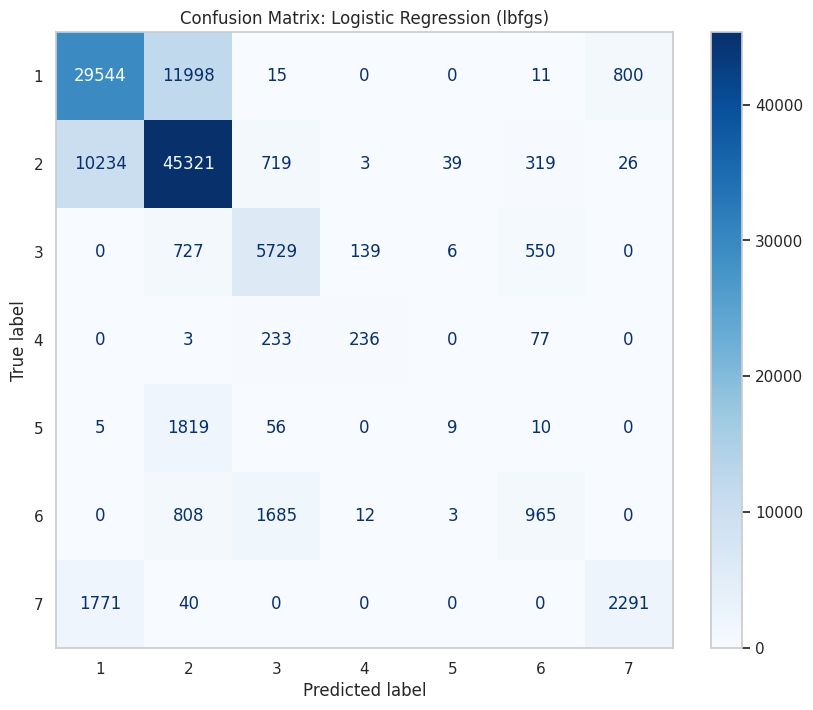

In [ ]:
import time

# Define the pipeline with 'lbfgs'
pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',      # Much faster for this data shape
        max_iter=2000,       # High limit to ensure convergence
        random_state=42,
        n_jobs=-1            # Uses all CPU cores
    ))
])

print("Starting training with lbfgs...")
t0 = time.time()

# Fit the model
pipeline.fit(X_train, y_train)

t1 = time.time()
print(f"Training Time: {t1 - t0:.1f} seconds")

# --- Evaluate ---
print("\nEvaluating...")
y_pred = pipeline.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    ax=ax,
    cmap='Blues',
    values_format='d'
)
plt.title("Confusion Matrix: Logistic Regression (lbfgs)")
plt.grid(False)
plt.show()

**Linear SVM**

Loaded dataframe shape: (581012, 55)
Train shape: (464809, 54)
Test shape : (116203, 54)

Starting GridSearchCV (Parallel)...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
GridSearchCV done in 336.79 sec
Best params: {'clf__C': 10.0}

Predicting on Test Set...

--- Final LinearSVC Results ---
Test Accuracy : 0.7114
Test Macro-F1 : 0.4563


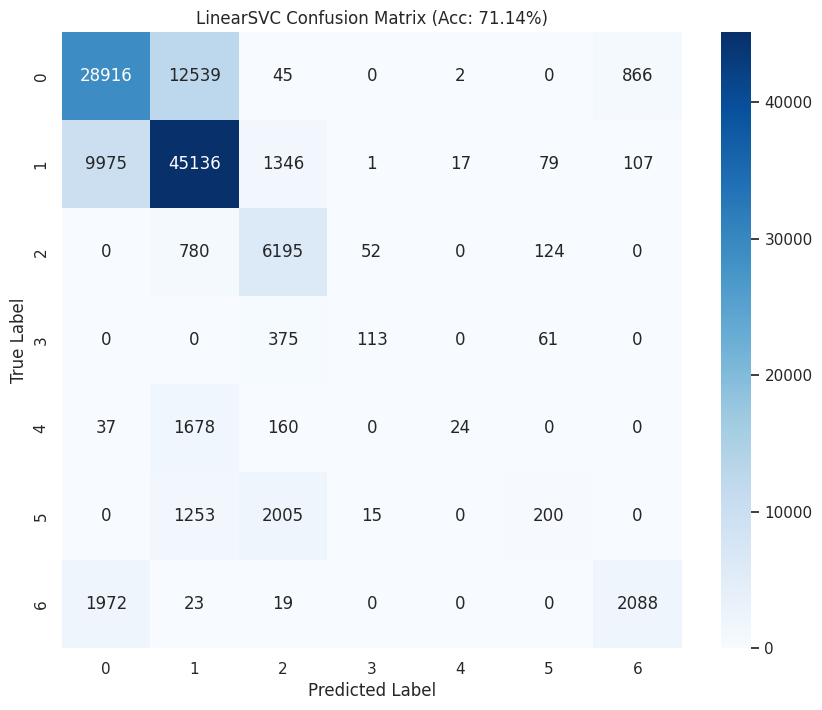


DONE.


7728

In [ ]:
import time, joblib, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

sns.set(style="whitegrid")
RANDOM_STATE = 42

DATA_PATH = "covtype.csv"
SUBSAMPLE = 1.0

# 1) Load dataset
df = pd.read_csv(DATA_PATH)
print(f"Loaded dataframe shape: {df.shape}")

# 2) Define Columns
continuous_cols = [
    'Elevation','Aspect','Slope',
    'Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]
target_col = 'Cover_Type' if 'Cover_Type' in df.columns else df.columns[-1]
feature_cols = [c for c in df.columns if c != target_col]

# 3) Cleaning & Subsampling
df = df.dropna(subset=[target_col])
df = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)
df[target_col] = df[target_col].astype(int)

if SUBSAMPLE < 1.0:
    print(f"Subsampling enabled: Using {SUBSAMPLE*100}% of data...")
    _, df = train_test_split(df, test_size=SUBSAMPLE, stratify=df[target_col], random_state=RANDOM_STATE)

# 4) Train-test split
X = df[feature_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

# 5) Pipeline Setup (Scaling is mandatory for SVM)
preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(), continuous_cols)],
    remainder='passthrough'
)

# 6) Tuned LinearSVC
# Using dual=False is faster for n_samples > n_features
pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', LinearSVC(random_state=RANDOM_STATE, dual=False, max_iter=2000))
])

# Reduced param grid for speed
param_grid = {
    'clf__C': [0.1, 1.0, 10.0],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
gs = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)

print("\nStarting GridSearchCV (Parallel)...")
t0 = time.time()
gs.fit(X_train, y_train)
t1 = time.time()
print(f"GridSearchCV done in {(t1 - t0):.2f} sec")
print("Best params:", gs.best_params_)

best_model = gs.best_estimator_

# 7) Final Evaluation
print("\nPredicting on Test Set...")
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average='macro')

print("\n--- Final LinearSVC Results ---")
print(f"Test Accuracy : {acc:.4f}")
print(f"Test Macro-F1 : {f1m:.4f}")

# 8) Confusion Matrix Plot with Values
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))

# annot=True adds the numbers
# fmt='d' ensures they are integers (no decimals)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title(f"LinearSVC Confusion Matrix (Acc: {acc:.2%})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("\nDONE.")
gc.collect()